# Creating H5Types definitions

In [1]:
!python3 ../scripts/make_h5types.py -c ../config/Microcircuit.yaml --output-path datasets/MiV_h5types.h5

numprocs=1


In [2]:
!h5ls -r ./datasets/MiV_h5types.h5

/                        Group
/H5Types                 Group
/H5Types/Population\ labels Type
/H5Types/Population\ projections Type
/H5Types/Population\ range Type
/H5Types/Populations     Dataset {4}
/H5Types/Valid\ population\ projections Dataset {10}


In [3]:
!h5dump -d /H5Types/Populations ./datasets/MiV_h5types.h5

HDF5 "./datasets/MiV_h5types.h5" {
DATASET "/H5Types/Populations" {
   DATATYPE  H5T_COMPOUND {
      H5T_STD_U64LE "Start";
      H5T_STD_U32LE "Count";
      H5T_ENUM {
         H5T_STD_U16LE;
         "OLM"              102;
         "PVBC"             101;
         "PYR"              100;
         "STIM"             0;
      } "Population";
   }
   DATASPACE  SIMPLE { ( 4 ) / ( 4 ) }
   DATA {
   (0): {
         0,
         1000,
         STIM
      },
   (1): {
         1000,
         80000,
         PYR
      },
   (2): {
         81000,
         1474,
         PVBC
      },
   (3): {
         82474,
         438,
         OLM
      }
   }
}
}


# Copying and compiling NMODL mechanisms

In [4]:
!cp ../mechanisms/*.mod .

In [5]:
!~/bin/nrnpython3/bin/nrnivmodl .

/home/igr/src/model/MiV/notebooks
Mod files: "./ch_CavL.mod" "./ch_CavN.mod" "./ch_HCNolm.mod" "./ch_HCNp.mod" "./ch_KCaS.mod" "./ch_Kdrfast.mod" "./ch_Kdrp.mod" "./ch_KvAdistp.mod" "./ch_KvA.mod" "./ch_KvAolm.mod" "./ch_KvAproxp.mod" "./ch_KvCaB.mod" "./ch_leak.mod" "./ch_Navaxonp.mod" "./ch_Nav.mod" "./ch_Navp.mod"

COBJS=''
 -> Compiling mod_func.cpp
 -> NMODL .././ch_CavL.mod
 -> NMODL .././ch_CavN.mod
 -> NMODL .././ch_HCNolm.mod
Translating ch_CavL.mod into /home/igr/src/model/MiV/notebooks/x86_64/ch_CavL.c
Notice: VERBATIM blocks are not thread safe
Translating ch_HCNolm.mod into /home/igr/src/model/MiV/notebooks/x86_64/ch_HCNolm.c
Translating ch_CavN.mod into /home/igr/src/model/MiV/notebooks/x86_64/ch_CavN.c
Notice: VERBATIM blocks are not thread safe
Notice: Assignment to the GLOBAL variable, "rexp", is not thread safe
Notice: Assignment to the GLOBAL variable, "rinf", is not thread safe
Notice: Assignment to the GLOBAL variable, "tau_r", is not thread safe
 -> NMODL .././ch_

# Generating soma coordinates and measuring distances

In [11]:
!mpirun.mpich -n 8 python3 ../scripts/generate_soma_coordinates.py -v \
    --config=Microcircuit.yaml --config-prefix=../config \
    --types-path=./datasets/MiV_h5types.h5 \
    --output-path=./datasets/Microcircuit_coords.h5 \
    --output-namespace='Generated Coordinates' 


numprocs=8
INFO:CA1.generate_soma_coordinates.py:8 ranks have been allocated
INFO:CA1:env.dataset_prefix = None
INFO:CA1:env.cell_selection_path = None
INFO:CA1.generate_soma_coordinates.py:Constructing alpha shape for volume: extents: ((0.0, 4000.0), (0.0, 4000.0), (0.0, 450.0))...
INFO:neural_geometry.geometry:Constructing volume triangulation...
INFO:neural_geometry.geometry:Constructing alpha shape...
INFO:CA1.generate_soma_coordinates.py:Constructing alpha shape for layers SO: extents: [[0.0, 0.0, 0.0], [4000.0, 4000.0, 100.0]]...
INFO:neural_geometry.geometry:Constructing volume triangulation...
INFO:neural_geometry.geometry:Constructing alpha shape...
INFO:CA1.generate_soma_coordinates.py:Constructing alpha shape for layers SP: extents: [[0.0, 0.0, 100.0], [4000.0, 4000.0, 150.0]]...
INFO:neural_geometry.geometry:Constructing volume triangulation...
INFO:neural_geometry.geometry:Constructing alpha shape...
INFO:CA1.generate_soma_coordinates.py:Constructing alpha shape for layers

DEBUG:rbf.pde.nodes:starting node dispersion iterations 6 of 10
DEBUG:rbf.pde.nodes:starting node dispersion iterations 7 of 10
DEBUG:rbf.pde.nodes:starting node dispersion iterations 8 of 10
DEBUG:rbf.pde.nodes:starting node dispersion iterations 9 of 10
DEBUG:rbf.pde.nodes:starting node dispersion iterations 10 of 10
DEBUG:rbf.pde.nodes:snapping nodes to boundary ...
DEBUG:rbf.pde.nodes:done
DEBUG:rbf.pde.nodes:orienting simplices ...
DEBUG:rbf.pde.nodes:done
DEBUG:rbf.pde.nodes:grouping boundary nodes and generating ghosts ...
DEBUG:rbf.pde.nodes:done
DEBUG:rbf.pde.nodes:sorting nodes ...
DEBUG:rbf.pde.nodes:done
DEBUG:rbf.pde.nodes:checking the quality of the generated nodes ...
DEBUG:rbf.pde.nodes:done
INFO:CA1.generate_soma_coordinates.py:155384 interior nodes out of 160000 nodes generated
INFO:CA1.generate_soma_coordinates.py:Population STIM: layer distribution is {'SO': 0, 'SP': 1000, 'SR': 0, 'SLM': 0}
INFO:CA1.generate_soma_coordinates.py:Generating 2000 nodes in layer SP for

INFO:CA1.generate_soma_coordinates.py:Rank 6: PVBC cell 110: 1532.183031 2964.126688 92.748467
INFO:CA1.generate_soma_coordinates.py:Rank 6: PVBC cell 118: 194.158644 1974.437996 5.864258
INFO:CA1.generate_soma_coordinates.py:Rank 6: PVBC cell 126: 873.187097 2020.042325 91.371780
INFO:CA1.generate_soma_coordinates.py:Rank 6: PVBC cell 134: 116.492572 1764.907858 10.866039
INFO:CA1.generate_soma_coordinates.py:Rank 6: PVBC cell 142: 371.066208 1326.503341 4.355532
INFO:CA1.generate_soma_coordinates.py:Rank 6: PVBC cell 150: 203.732950 1034.699146 85.232098
INFO:CA1.generate_soma_coordinates.py:Rank 6: PVBC cell 158: 932.451245 1812.915168 12.570945
INFO:CA1.generate_soma_coordinates.py:Rank 6: PVBC cell 166: 746.662347 1419.694786 5.234979
INFO:CA1.generate_soma_coordinates.py:Rank 6: PVBC cell 174: 1566.165936 2791.125430 9.478849
INFO:CA1.generate_soma_coordinates.py:Rank 6: PVBC cell 182: 1563.109607 2407.149926 6.219451
INFO:CA1.generate_soma_coordinates.py:Rank 6: PVBC cell 190: 1

INFO:CA1.generate_soma_coordinates.py:Rank 5: PYR cell 2605: 256.890059 3602.911368 129.365599
INFO:CA1.generate_soma_coordinates.py:Rank 5: PYR cell 2613: 184.146899 3558.097996 125.730508
INFO:CA1.generate_soma_coordinates.py:Rank 5: PYR cell 2621: 320.933728 3628.433907 133.953237
INFO:CA1.generate_soma_coordinates.py:Rank 5: PYR cell 2637: 77.652847 3498.955111 136.044911
INFO:CA1.generate_soma_coordinates.py:Rank 5: PYR cell 2653: 167.315106 3544.736957 132.308589
INFO:CA1.generate_soma_coordinates.py:Rank 5: PYR cell 2685: 140.591285 3519.265579 131.725505
INFO:CA1.generate_soma_coordinates.py:Rank 5: PYR cell 2693: 190.448470 3551.609657 108.847305
INFO:CA1.generate_soma_coordinates.py:Rank 5: PYR cell 2701: 153.826388 3514.583746 106.224794
INFO:CA1.generate_soma_coordinates.py:Rank 5: PYR cell 2717: 28.628443 3512.669088 135.973349
INFO:CA1.generate_soma_coordinates.py:Rank 5: PYR cell 2733: 816.846282 3885.694952 114.679911
INFO:CA1.generate_soma_coordinates.py:Rank 5: PYR ce

INFO:CA1.generate_soma_coordinates.py:Rank 4: PYR cell 10724: 134.869896 3090.255432 119.523582
INFO:CA1.generate_soma_coordinates.py:Rank 4: PYR cell 10732: 123.822669 3082.484809 136.067194
INFO:CA1.generate_soma_coordinates.py:Rank 4: PYR cell 10740: 74.229967 3051.220204 111.775102
INFO:CA1.generate_soma_coordinates.py:Rank 4: PYR cell 10748: 0.326061 3050.568046 145.244487
INFO:CA1.generate_soma_coordinates.py:Rank 4: PYR cell 10756: 3365.509340 3858.836421 149.002526
INFO:CA1.generate_soma_coordinates.py:Rank 4: PYR cell 10764: 3264.501671 3866.526661 118.284992
INFO:CA1.generate_soma_coordinates.py:Rank 4: PYR cell 10772: 3395.397397 3840.362347 140.118035
INFO:CA1.generate_soma_coordinates.py:Rank 4: PYR cell 10796: 3483.577455 3820.223762 149.982360
INFO:CA1.generate_soma_coordinates.py:Rank 4: PYR cell 10804: 3556.877174 3779.653478 112.083663
INFO:CA1.generate_soma_coordinates.py:Rank 4: PYR cell 10820: 3548.156137 3782.075145 136.176460
INFO:CA1.generate_soma_coordinates.py

INFO:CA1.generate_soma_coordinates.py:Rank 4: PYR cell 16036: 395.620313 3148.952876 134.119432
INFO:CA1.generate_soma_coordinates.py:Rank 4: PYR cell 16044: 414.771001 3155.059672 149.922990
INFO:CA1.generate_soma_coordinates.py:Rank 4: PYR cell 16052: 490.970118 3187.341049 113.207332
INFO:CA1.generate_soma_coordinates.py:Rank 4: PYR cell 16060: 370.284946 3122.255141 109.849164
INFO:CA1.generate_soma_coordinates.py:Rank 4: PYR cell 16068: 306.915846 3077.261462 120.897467
INFO:CA1.generate_soma_coordinates.py:Rank 4: PYR cell 16076: 34.740161 2898.445622 114.464387
INFO:CA1.generate_soma_coordinates.py:Rank 4: PYR cell 16092: 926.195504 3429.971725 111.464824
INFO:CA1.generate_soma_coordinates.py:Rank 4: PYR cell 16100: 948.407515 3442.261016 133.050199
INFO:CA1.generate_soma_coordinates.py:Rank 4: PYR cell 16116: 556.810772 3232.523337 140.936650
INFO:CA1.generate_soma_coordinates.py:Rank 4: PYR cell 16124: 625.021256 3267.097694 117.504191
INFO:CA1.generate_soma_coordinates.py:Ran

INFO:CA1.generate_soma_coordinates.py:Rank 4: PYR cell 20316: 1356.578834 3492.031570 131.944740
INFO:CA1.generate_soma_coordinates.py:Rank 4: PYR cell 20324: 1454.080656 3527.683028 149.526347
INFO:CA1.generate_soma_coordinates.py:Rank 4: PYR cell 20340: 1733.228439 3591.940887 112.662189
INFO:CA1.generate_soma_coordinates.py:Rank 4: PYR cell 20356: 2037.717291 3644.769507 114.185031
INFO:CA1.generate_soma_coordinates.py:Rank 4: PYR cell 20364: 3575.669192 3544.394515 131.797637
INFO:CA1.generate_soma_coordinates.py:Rank 4: PYR cell 20380: 3665.346831 3521.137535 126.230593
INFO:CA1.generate_soma_coordinates.py:Rank 4: PYR cell 20388: 3057.882864 3659.225509 132.767084
INFO:CA1.generate_soma_coordinates.py:Rank 4: PYR cell 20396: 2992.077761 3654.528447 133.506256
INFO:CA1.generate_soma_coordinates.py:Rank 4: PYR cell 20404: 3162.779611 3635.565836 116.288448
INFO:CA1.generate_soma_coordinates.py:Rank 4: PYR cell 20412: 3080.017321 3648.120241 103.052728
INFO:CA1.generate_soma_coordin

IOPub data rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_data_rate_limit`.

Current values:
NotebookApp.iopub_data_rate_limit=1000000.0 (bytes/sec)
NotebookApp.rate_limit_window=3.0 (secs)



In [14]:
!mpirun.mpich -n 8 python3 ..mpirun.mpich -n 8 python3 ./scripts/measure_distances.py -v \
             -i PYR -i PVBC -i OLM \
             --config=config/Microcircuit.yaml \
             --coords-path=./datasets/Microcircuit_coords.h5/scripts/measure_distances.py -v \
             -i PYR -i PVBC -i OLM -i STIM \
             --config=../config/Microcircuit.yaml \
             --coords-path=./datasets/Microcircuit_coords.h5

numprocs=8
INFO:MiV:env.dataset_prefix = None
INFO:MiV:env.cell_selection_path = None
INFO:MiV.../scripts/measure_distances.py:Reading population coordinates...
INFO:MiV.../scripts/measure_distances.py:Creating distance interpolant...
INFO:neural_geometry.geometry:Creating volume: min_l = 0.000000 max_l = 450.000000...
INFO:neural_geometry.geometry:Computing reference distances...
INFO:neural_geometry.geometry:Origin coordinates: 2000.000000 2000.000000 450.010000
INFO:neural_geometry.geometry:Origin position: 0.500000 0.500000 extent: 4000.020000 4000.020000
INFO:neural_geometry.geometry:Origin ranges: -2000.010000 : 2000.010000 -2000.010000 : 2000.010000
INFO:neural_geometry.geometry:Creating volume triangulation...
INFO:neural_geometry.geometry:Constructing alpha shape...
INFO:neural_geometry.geometry:Generating 2000 nodes (20 iterations)...
INFO:neural_geometry.geometry:1569 interior nodes generated (20 iterations)
INFO:neural_geometry.geometry:Inverse interpolation of UVL coordina

INFO:neural_geometry.geometry:gid 82448: distances: 1942.470205 840.721187
INFO:neural_geometry.geometry:gid 82456: distances: 1967.649156 -1395.071595
INFO:neural_geometry.geometry:gid 82464: distances: 1992.416736 -139.288455
INFO:neural_geometry.geometry:gid 82472: distances: 1997.872059 267.442624
INFO:neural_geometry.geometry:Computing soma distances for 80000 cells from population PYR...
INFO:neural_geometry.geometry:gid 1000: distances: -1999.999996 99.801755
INFO:neural_geometry.geometry:gid 1008: distances: -1999.999998 -1003.431337
INFO:neural_geometry.geometry:gid 1016: distances: -1999.999999 -1620.556763
INFO:neural_geometry.geometry:gid 1024: distances: -1999.999999 -1742.497374
INFO:neural_geometry.geometry:gid 1032: distances: -1999.999994 1705.963861
INFO:neural_geometry.geometry:gid 1040: distances: -1999.983869 627.666011
INFO:neural_geometry.geometry:gid 1048: distances: -1999.922140 -246.292482
INFO:neural_geometry.geometry:gid 1056: distances: -1999.900309 -1295.9

INFO:neural_geometry.geometry:gid 6680: distances: -1713.079190 893.497553
INFO:neural_geometry.geometry:gid 6688: distances: -1712.801389 81.334714
INFO:neural_geometry.geometry:gid 6696: distances: -1712.655639 -1256.479676
INFO:neural_geometry.geometry:gid 6704: distances: -1712.381317 -1971.217282
INFO:neural_geometry.geometry:gid 6712: distances: -1712.120544 -1883.832175
INFO:neural_geometry.geometry:gid 6720: distances: -1712.015471 -704.689211
INFO:neural_geometry.geometry:gid 6728: distances: -1711.790006 439.751705
INFO:neural_geometry.geometry:gid 6736: distances: -1711.641813 -446.877443
INFO:neural_geometry.geometry:gid 6744: distances: -1711.220428 -1536.262146
INFO:neural_geometry.geometry:gid 6752: distances: -1710.964961 1514.785394
INFO:neural_geometry.geometry:gid 6760: distances: -1710.612821 -171.409549
INFO:neural_geometry.geometry:gid 6768: distances: -1710.367366 1476.233880
INFO:neural_geometry.geometry:gid 6776: distances: -1710.139187 708.673824
INFO:neural_g

INFO:neural_geometry.geometry:gid 13008: distances: -1398.331541 769.983882
INFO:neural_geometry.geometry:gid 13016: distances: -1398.028136 203.372554
INFO:neural_geometry.geometry:gid 13024: distances: -1397.773435 893.359858
INFO:neural_geometry.geometry:gid 13032: distances: -1397.411865 -975.873414
INFO:neural_geometry.geometry:gid 13040: distances: -1397.330690 -1934.438689
INFO:neural_geometry.geometry:gid 13048: distances: -1396.948304 -1256.124817
INFO:neural_geometry.geometry:gid 13056: distances: -1396.601255 762.516597
INFO:neural_geometry.geometry:gid 13064: distances: -1396.066833 -552.397829
INFO:neural_geometry.geometry:gid 13072: distances: -1395.635011 -1817.017256
INFO:neural_geometry.geometry:gid 13080: distances: -1395.217590 -542.455690
INFO:neural_geometry.geometry:gid 13088: distances: -1394.837831 -1801.710891
INFO:neural_geometry.geometry:gid 13096: distances: -1394.367674 910.851801
INFO:neural_geometry.geometry:gid 13104: distances: -1393.884336 519.329830
I

INFO:neural_geometry.geometry:gid 23648: distances: -868.108035 -1556.601135
INFO:neural_geometry.geometry:gid 23656: distances: -867.596803 -358.129641
INFO:neural_geometry.geometry:gid 23664: distances: -867.303714 -1590.075958
INFO:neural_geometry.geometry:gid 23672: distances: -866.865848 -1887.372985
INFO:neural_geometry.geometry:gid 23680: distances: -866.423831 -1443.484436
INFO:neural_geometry.geometry:gid 23688: distances: -865.952273 -810.667238
INFO:neural_geometry.geometry:gid 23696: distances: -865.403319 1438.232904
INFO:neural_geometry.geometry:gid 23704: distances: -864.689941 1083.751460
INFO:neural_geometry.geometry:gid 23712: distances: -864.109497 866.512935
INFO:neural_geometry.geometry:gid 23720: distances: -863.464601 -163.781619
INFO:neural_geometry.geometry:gid 23728: distances: -862.792360 -920.609620
INFO:neural_geometry.geometry:gid 23736: distances: -862.100098 444.391109
INFO:neural_geometry.geometry:gid 23744: distances: -861.461914 587.533198
INFO:neural

INFO:neural_geometry.geometry:gid 42504: distances: 74.763423 -311.513797
INFO:neural_geometry.geometry:gid 42512: distances: 75.791743 -154.890506
INFO:neural_geometry.geometry:gid 42520: distances: 76.641839 -1271.969605
INFO:neural_geometry.geometry:gid 42528: distances: 77.218991 1039.903559
INFO:neural_geometry.geometry:gid 42536: distances: 77.879388 -1716.456023
INFO:neural_geometry.geometry:gid 42544: distances: 78.309567 909.805659
INFO:neural_geometry.geometry:gid 42552: distances: 78.547113 -1336.081788
INFO:neural_geometry.geometry:gid 42560: distances: 78.756097 -1808.461135
INFO:neural_geometry.geometry:gid 42568: distances: 79.081538 101.545895
INFO:neural_geometry.geometry:gid 42576: distances: 79.530758 953.265131
INFO:neural_geometry.geometry:gid 42584: distances: 79.722410 1590.375726
INFO:neural_geometry.geometry:gid 42592: distances: 80.102046 -78.791874
INFO:neural_geometry.geometry:gid 42600: distances: 80.638665 -1938.144889
INFO:neural_geometry.geometry:gid 426

INFO:neural_geometry.geometry:gid 63896: distances: 1143.876213 940.038080
INFO:neural_geometry.geometry:gid 63904: distances: 1145.390374 1046.236079
INFO:neural_geometry.geometry:gid 63912: distances: 1146.291252 790.012934
INFO:neural_geometry.geometry:gid 63920: distances: 1146.657707 753.654780
INFO:neural_geometry.geometry:gid 63928: distances: 1147.009754 -1760.176590
INFO:neural_geometry.geometry:gid 63936: distances: 1147.135736 1822.040032
INFO:neural_geometry.geometry:gid 63944: distances: 1147.684805 -970.255372
INFO:neural_geometry.geometry:gid 63952: distances: 1148.524650 512.593257
INFO:neural_geometry.geometry:gid 63960: distances: 1148.805900 685.583491
INFO:neural_geometry.geometry:gid 63968: distances: 1149.193105 -910.647462
INFO:neural_geometry.geometry:gid 63976: distances: 1149.549553 1376.793938
INFO:neural_geometry.geometry:gid 63984: distances: 1149.863274 1001.913569
INFO:neural_geometry.geometry:gid 63992: distances: 1150.039786 -331.288943
INFO:neural_geom

INFO:neural_geometry.geometry:gid 77688: distances: 1830.329336 1110.445551
INFO:neural_geometry.geometry:gid 77696: distances: 1830.597647 1472.931878
INFO:neural_geometry.geometry:gid 77704: distances: 1830.946035 1598.154534
INFO:neural_geometry.geometry:gid 77712: distances: 1831.468985 1793.736565
INFO:neural_geometry.geometry:gid 77720: distances: 1831.852040 507.576411
INFO:neural_geometry.geometry:gid 77728: distances: 1832.148670 -525.947389
INFO:neural_geometry.geometry:gid 77736: distances: 1832.567858 -1736.699218
INFO:neural_geometry.geometry:gid 77744: distances: 1833.009267 509.898433
INFO:neural_geometry.geometry:gid 77752: distances: 1834.149158 -451.498415
INFO:neural_geometry.geometry:gid 77760: distances: 1834.590318 -1960.681468
INFO:neural_geometry.geometry:gid 77768: distances: 1835.141834 172.195308
INFO:neural_geometry.geometry:gid 77776: distances: 1835.640124 -1493.272735
INFO:neural_geometry.geometry:gid 77784: distances: 1836.307850 31.943844
INFO:neural_ge

INFO:MiV.../scripts/measure_distances.py:Writing distances for population PVBC...
INFO:MiV.../scripts/measure_distances.py:Writing distances for population PYR...
INFO:MiV.../scripts/measure_distances.py:Writing distances for population STIM...


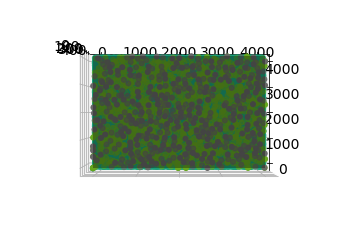

In [15]:
%run ../scripts/plot_coords_in_volume.py \
--config ../config/Microcircuit.yaml \
--coords-path datasets/Microcircuit_coords.h5 \
-i PYR -i PVBC -i OLM

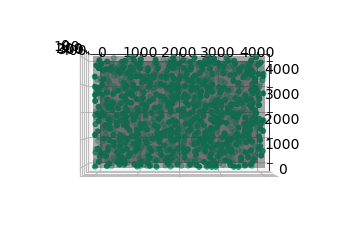

In [16]:
%run ../scripts/plot_coords_in_volume.py \
--config ../config/Microcircuit.yaml \
--coords-path datasets/Microcircuit_coords.h5 \
-i STIM

# Distributing synapses along dendritic trees

In [1]:
!cp ../datasets/Microcircuit/PYR_tree.h5 datasets/PYR_forest.h5

In [1]:
%run ../scripts/distribute_synapse_locs.py \
             --template-path ../templates \
             --config-prefix ../config \
              --config=Microcircuit.yaml \
              --populations PYR \
              --forest-path=./datasets/PYR_forest.h5 \
              --output-path=./datasets/PYR_forest.h5 \
              --distribution=poisson \
              --io-size=1 -v

INFO:MiV.distribute_synapse_locs.py:1 ranks have been allocated
INFO:MiV:env.dataset_prefix = None
INFO:MiV:env.cell_selection_path = None
INFO:MiV.distribute_synapse_locs.py:Rank 0 population: PYR
INFO:MiV.neuron_utils:Loaded PoolosPyramidalCell from ../templates/PoolosPyramidalCell.hoc
INFO:MiV.distribute_synapse_locs.py:Rank 0 gid: 1000: {'x': array([ 0.      ,  0.      ,  0.      , ..., 47.959183, 48.97959 ,
       50.      ], dtype=float32), 'y': array([0.        , 0.25      , 0.5       , ..., 0.8926153 , 0.89261526,
       0.8926152 ], dtype=float32), 'z': array([0., 0., 0., ..., 0., 0., 0.], dtype=float32), 'radius': array([1.7, 1.7, 1.7, ..., 0.5, 0.5, 0.5], dtype=float32), 'layer': array([6, 6, 6, ..., 6, 6, 6], dtype=int8), 'parent': array([   -1,     0,     1, ..., 10342, 10343, 10344], dtype=int32), 'swc_type': array([1, 1, 1, ..., 7, 7, 7], dtype=int8), 'section': array([  0,   0,   0, ..., 201, 201, 201], dtype=uint16), 'section_topology': {'num_sections': 202, 'nodes': {

INFO:MiV.distribute_synapse_locs.py:Rank 0 took 1.01 s to compute 33485 synapse locations for PYR gid: 1000
layer 8: excitatory synapses: 5671
layer 8: inhibitory synapses: 371
layer 9: excitatory synapses: 16259
layer 9: inhibitory synapses: 613
layer 5: excitatory synapses: 10105
layer 5: inhibitory synapses: 395
layer 6: excitatory synapses: 13
layer 6: inhibitory synapses: 58
swc_type 4: excitatory synapses: 21930
swc_type 4: inhibitory synapses: 790
swc_type 3: excitatory synapses: 10105
swc_type 3: inhibitory synapses: 395
swc_type 1: excitatory synapses: 13
swc_type 1: inhibitory synapses: 18
swc_type 7: excitatory synapses: 0
swc_type 7: inhibitory synapses: 234
INFO:MiV.distribute_synapse_locs.py:Rank 0 gid is None
INFO:MiV.distribute_synapse_locs.py:Population: PYR, 1 ranks took 1.09 s to compute synapse locations for 1 cells
INFO:MiV.distribute_synapse_locs.py:PYR layer 8: mean excitatory synapses per cell: 5671.00
PYR layer 8: mean inhibitory synapses per cell: 371.00
PYR l

# Generating connections

In [1]:
!mpirun.mpich -n 8 python3 ../scripts/generate_distance_connections.py \
    --config-prefix=../config \
    --config=Microcircuit.yaml \
    --forest-path=datasets/PYR_forest.h5 \
    --connectivity-path=datasets/Microcircuit_connections.h5 \
    --connectivity-namespace=Connections \
    --coords-path=datasets/Microcircuit_coords.h5 \
    --coords-namespace='Generated Coordinates' \
    --io-size=1 --cache-size=20 --write-size=1 -v --dry-run

numprocs=8
INFO:MiV:env.dataset_prefix = None
INFO:MiV:env.cell_selection_path = None
INFO:MiV.generate_distance_connections.py:Reading OLM coordinates...
INFO:MiV.generate_distance_connections.py:Reading PVBC coordinates...
INFO:MiV.generate_distance_connections.py:Reading PYR coordinates...
INFO:MiV.generate_distance_connections.py:Reading STIM coordinates...
INFO:MiV.generate_distance_connections.py:Generating connectivity for populations ['PYR']...
INFO:MiV.generate_distance_connections.py:Generating connection probabilities for population PYR...
INFO:MiV.connections:population STIM: layer: default: 
u width: 500.0
v width: 500.0
u scale_factor: 166.66666666666666
v scale_factor: 166.66666666666666

INFO:MiV.connections:population STIM: layer: default: 
u width: 500.0
v width: 500.0
u scale_factor: 166.66666666666666
v scale_factor: 166.66666666666666

INFO:MiV.connections:population STIM: layer: default: 
u width: 500.0
v width: 500.0
u scale_factor: 166.66666666666666
v scale_fac

INFO:MiV.connections:Rank 0 has 29 possible sources from population STIM for destination: PYR, layer 6, gid: 1000; max U distance: 443.20 min U distance: 0.00
INFO:MiV.connections:Rank 0 has 29 possible sources from population STIM for destination: PYR, layer 5, gid: 1000; max U distance: 443.20 min U distance: 0.00
INFO:MiV.connections:Rank 0 has 29 possible sources from population STIM for destination: PYR, layer 8, gid: 1000; max U distance: 443.20 min U distance: 0.00
INFO:MiV.connections:Rank 0 has 29 possible sources from population STIM for destination: PYR, layer 9, gid: 1000; max U distance: 443.20 min U distance: 0.00
INFO:MiV.connections:Rank 0 took 3.89 s to compute 33485 edges for destination: PYR, gid: 1000
INFO:MiV.connections:Rank 1 destination gid is None
INFO:MiV.connections:Rank 2 destination gid is None
INFO:MiV.connections:Rank 3 destination gid is None
INFO:MiV.connections:Rank 4 destination gid is None
INFO:MiV.connections:Rank 5 destination gid is None
INFO:MiV.